# A2: Image classification in the browser

In this assignment, you will gain real-world experience with image classification on small datasets - a common scenario in practice. There are three parts.

1. First, you will train a model on a small existing dataset.

2. Next,  you will collect a small dataset yourself. Of course, in practice there often isn’t  a dataset available for tasks you care about, so it’s valuable to get a feel for this process. You will train a small model from scratch, then use data augmentation to improve accuracy.

3. Finally, you will run your model from part two in a webpage using TensorFlow.js. A user will be able to upload a photo, and your model will classify it.

## Instructions

Please complete this notebook by searching for **"TODO"**.

## Submission instructions

Please submit this assignment on Moodle by uploading a Jupyter notebook that includes saved output. If you are working in Colab, you can prepare your notebook for submission by ensuring that runs end-to-end, then saving and downloading it:

1. ```Runtime -> Restart and run all```
1. ```File -> Save```
1. ```File -> Download.ipynb```

Note: you will need to include a screenshot of your model running in a webpage for part 3, see the final TODO at the bottom of this notebook.

## Setup instructions
1. If you are running this notebook in Colab, make sure a GPU is enabled (```Edit -> Notebook settings -> Hardware accelerator```).

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


## 1a) Flowers

In this part of the assignment, you will train a model on a small existing dataset (flowers).

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

### Download the flowers dataset

In [ ]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228813984/228813984 [==============================] - 6s 0us/step
/root/.keras/datasets/flower_photos


### Write an input pipeline from scratch
There are several ways to load images in TensorFlow. Later in this assignment, you'll use the [Keras preprocessing utilities](https://keras.io/preprocessing/image/). For starters, though, you'll see how-to write your own using ```tf.data```, based on this [tutorial](https://www.tensorflow.org/beta/tutorials/load_data/images). This is valuable to do once (just so you can see how the nuts and bolts work) before using the higher level utils. This code is written for you as an example. Follow along and try to understand each piece.


In [ ]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [ ]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/sunflowers/14858674096_ed0fc1a130.jpg',
 '/root/.keras/datasets/flower_photos/tulips/5680695867_baff72fc7c.jpg',
 '/root/.keras/datasets/flower_photos/roses/3276552939_8c31b22d3e.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/4746668678_0e2693b1b9_n.jpg',
 '/root/.keras/datasets/flower_photos/daisy/8710109684_e2c5ef6aeb_n.jpg']

### Get to know your data

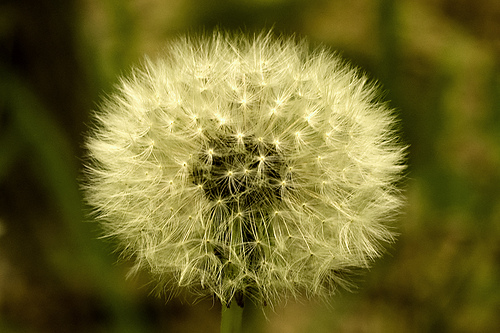

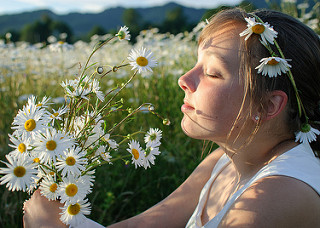

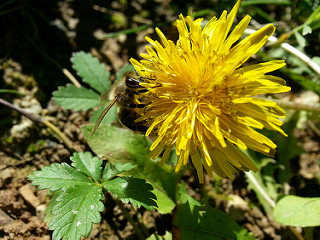

In [ ]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

### Classes are given by directory names

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [ ]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [3, 4, 2, 3, 0, 2, 2, 2, 1, 1]


### Create a train/test split

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)

### Display a few images and their labels

dandelion


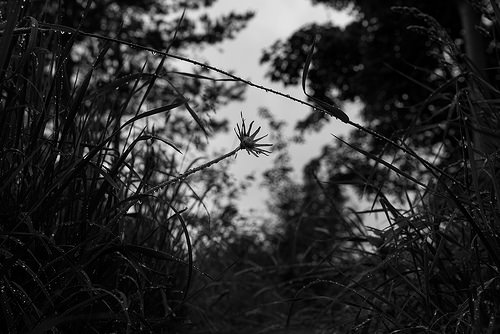


tulips


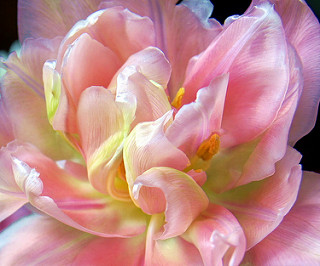


daisy


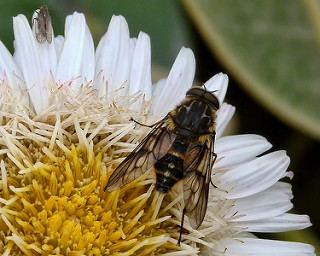

In [ ]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

### Begin using TensorFlow ops to read and decode the images

In [ ]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [ ]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(228, 320, 3)
<dtype: 'uint8'>


In [ ]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


### Wrap those in a function
Tip: pay careful attention to the preprocessing. When you deploy models in the browser, you will need to ensure that images are preprocessed identically in JavaScript as they are in Python.

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

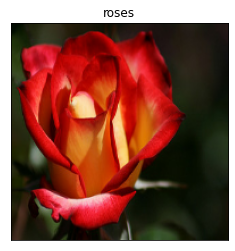

In [ ]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

### Build an input pipeline to return images and labels
I realize this is complicated. The problem we're trying to solve using tf.data is performance (we want our preprocessing to run in C, but to write our code in Python). There are a bunch of advanced tricks you can do with tf.data as well (e.g. prefetching images to the GPU).

Note: although your *peak* performance can be higher, it's also very easy to make mistakes and end up with code that's super slow. Always benchmark your input pipelines before using them (shown in a bit).

In [ ]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/8516036987_8a06dfe1b5_n.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/1240626292_52cd5d7fb1_m.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/5876455546_32049e5585.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/6061175433_95fdb12f32_n.jpg', shape=(), dtype=string)


In [ ]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [ ]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

roses
sunflowers
daisy
sunflowers


In [ ]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) roses
(192, 192, 3) sunflowers


### Batch and shuffle
Why do we need to specify a shuffle_size parameter? tf.data works with streams (it doesn't know their length). To shuffle items, we maintain an in-memory buffer of this size.

In [ ]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


At this point, you could use the dataset above to train a model with ```model.fit(ds)``` but first, let's improve performance. As written, the dataset will load each image off disk, one at a time (super slow). Instead, we want to cache them in memory.

### Improve performance

In [ ]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching
This is a small dataset, so let's keep it in memory. The first time we iterate over this dataset, images will be loaded off disk, then cached. The first iteration will be quite slow, and subsequent ones will be faster. Let's show that.

In [ ]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
21.82 Batches/s
698.22 Images/s
Total time: 3.9414353370666504s


Now that the cache is built, iteration will be much faster.

In [ ]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
365.07 Batches/s
11682.26 Images/s
Total time: 0.23557090759277344s


### How-to use on-disk caching

If the dataset did not fit into memory, you could use a cache file on disk, like this:

```
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.shuffle(buffer_size=BUFFER_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
```

This can be useful to perform expensive preprocessing only once, and/or to improve file I/O (TF saves the cache file in an efficient format - it can be faster to read one large file than a bunch of small ones). For now, we'll keep it in memory.

In [ ]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

### Finally, we have a fast pipeline ready to go, written from scratch
Now, let's define a model.

## 1b) Create a simple CNN
This is our baseline model, it will not be very accurate. You'll improve it below.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 16)       0         
 )                                                               
                                                                 
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

### Tip: pay attention to the size of the model
Later, when you export a model to run in the webpage, you will want a small one (in terms of the number of parameters) that downloads quickly. Notice how much more efficient convolutional layers are than the dense layers (ask yourself,why?)

### Tip: pay attention to exactly how your images are preprocessed
Later, when you run your model in a browser, you'll need to preprocess images in JavaScript in exactly the same way.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 144400)            0         
                                                                 
 dense (Dense)               (None, 5)                 722005    
                                                                 
Total params: 722,453
Trainable params: 722,453
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# I realize we're not using a separate test set, that's fine
# for this assignment
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 14s 61ms/step - loss: 2.5652 - accuracy: 0.4328 - val_loss: 1.2225 - val_accuracy: 0.4946
Epoch 2/5
86/86 [==============================] - 2s 19ms/step - loss: 0.9997 - accuracy: 0.6079 - val_loss: 1.1099 - val_accuracy: 0.5425
Epoch 3/5
86/86 [==============================] - 2s 19ms/step - loss: 0.7457 - accuracy: 0.7442 - val_loss: 1.1884 - val_accuracy: 0.5534
Epoch 4/5
86/86 [==============================] - 2s 19ms/step - loss: 0.5049 - accuracy: 0.8423 - val_loss: 1.1229 - val_accuracy: 0.5850
Epoch 5/5
86/86 [==============================] - 2s 19ms/step - loss: 0.3503 - accuracy: 0.9099 - val_loss: 1.1877 - val_accuracy: 0.5828


### Make predictions on a single image
Tip: models are implemented to make predictions on batches of images for efficiency. This means that to make a prediction on a single image, you'll need to first wrap it in a batch. The syntax can feel a little unusual at first, but gets easier with time.

In [ ]:
# load an image off disk
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

print(img.shape) # before

#########
## TODO: your code here
## use tf.expand_dims to create an empty batch dimension
## the starting image shape is (192, 192, 3)
## you want it to be (1, 192, 192, 3)
## that's read as "a batch of 1 image, with 192 rows, 192 cols,
## and 3 color channels"
#########
# im_batch = None # YOUR CODE HERE, use tf.expand_dims
im_batch = tf.expand_dims(img, axis=0)

print(im_batch.shape) # after

# make predictions
batch_pred = model.predict(im_batch) # returns a list of predictions
pred = batch_pred[0]

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(192, 192, 3)
(1, 192, 192, 3)
1/1 [==============================] - 0s 100ms/step
Prediction roses
Actual roses


### TODO: Improve accuracy
In the code cell below, write a new model that's more accurate than the baseline above. Define and train your model, and create plots of loss / accuracy as a function of epochs. Try to train your model to high accuracy, without overfitting. For this assignment, it is not necessary to build a super accurate model (just experiment a bit and try to improve over the baseline).

Epoch 1/15
86/86 [==============================] - 7s 63ms/step - loss: 1.6241 - accuracy: 0.2456 - val_loss: 1.5561 - val_accuracy: 0.2233
Epoch 2/15
86/86 [==============================] - 5s 61ms/step - loss: 1.5110 - accuracy: 0.3027 - val_loss: 1.4338 - val_accuracy: 0.3824
Epoch 3/15
86/86 [==============================] - 5s 61ms/step - loss: 1.4330 - accuracy: 0.3746 - val_loss: 1.4202 - val_accuracy: 0.3791
Epoch 4/15
86/86 [==============================] - 5s 61ms/step - loss: 1.3357 - accuracy: 0.4320 - val_loss: 1.2893 - val_accuracy: 0.4161
Epoch 5/15
86/86 [==============================] - 5s 61ms/step - loss: 1.2841 - accuracy: 0.4662 - val_loss: 1.1826 - val_accuracy: 0.5120
Epoch 6/15
86/86 [==============================] - 5s 61ms/step - loss: 1.1459 - accuracy: 0.5327 - val_loss: 1.1183 - val_accuracy: 0.5425
Epoch 7/15
86/86 [==============================] - 5s 61ms/step - loss: 1.0890 - accuracy: 0.5665 - val_loss: 1.0135 - val_accuracy: 0.5948
Epoch 8/15
86

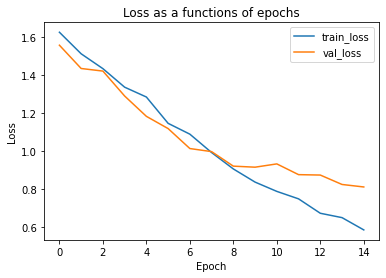

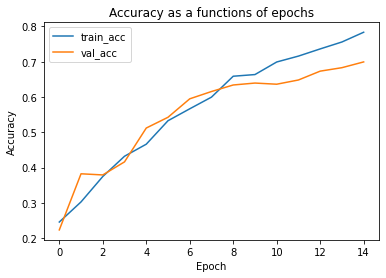

In [ ]:
# TODO: your code here
model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2,2), (2,2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2,2), (2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(96, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2,2), (2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(96, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2,2), (2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history = model.fit(train_ds, validation_data=test_ds, epochs=15)

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss as a functions of epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy as a functions of epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 1c) Practice deploying your flowers classifier using TensorFlow.js
In the final part of the assignment, you'll export the model you built to classify images from your house/apartment/campus, and get it working in the browser. If you're new to JavaScript (as most of us are), the mechanics will be difficult at first.

Let's practice by exporting your flowers classifier, and getting it working with TensorFlow.js (the starter code provided is written to work with flowers model).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save your model

In [ ]:
model.save("/content/my_model.h5")

In [ ]:
!ls -lha

total 42M
drwxr-xr-x 1 root root 4.0K Feb  5 12:45 .
drwxr-xr-x 1 root root 4.0K Feb  5 12:40 ..
drwxr-xr-x 4 root root 4.0K Feb  2 14:39 .config
drwx------ 5 root root 4.0K Feb  5 12:44 drive
-rw-r--r-- 1 root root  42M Feb  5 12:45 my_model.h5
drwxr-xr-x 1 root root 4.0K Feb  2 14:40 sample_data


### Download your saved model to your local machine

In [ ]:
# from google.colab import files
# files.download("/content/my_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Visit notebook #2 (a2-2.ipynb on Moodle) to convert your saved model into to TensorFlow.js format

Follow the instructions there to prepare a webpage to run your flowers model in the browser. Once you have that working, you can continue with the rest of this assignment in this notebook.

## 1d) Classify flowers using transfer learning

In this part of the assignment, you'll use transfer learning to take advantage of a large pretrained model. It is not necesary to deploy this part in the browser.


Read this tutorial before completing this section:
* https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
## TODO: your code here
# Choose a pretrained model, and import the application
# See https://keras.io/applications/ for a few choices
# When you import the model, you will want to remove the
# final dense layer that performs classification (include_top=False)
# you will also want to import weights from ImageNet,
# and you will want to specify the input shape to match your images.

#base_model = None # fix me. base_model = tf.keras.applications...
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass

feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 512)


In [ ]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [ ]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 15s 171ms/step - loss: 1.4632 - accuracy: 0.4055 - val_loss: 1.3054 - val_accuracy: 0.5381
Epoch 2/5
86/86 [==============================] - 13s 152ms/step - loss: 1.1773 - accuracy: 0.6166 - val_loss: 1.1188 - val_accuracy: 0.6122
Epoch 3/5
86/86 [==============================] - 13s 154ms/step - loss: 1.0230 - accuracy: 0.6701 - val_loss: 0.9953 - val_accuracy: 0.6928
Epoch 4/5
86/86 [==============================] - 14s 158ms/step - loss: 0.9267 - accuracy: 0.6991 - val_loss: 0.9193 - val_accuracy: 0.6983
Epoch 5/5
86/86 [==============================] - 14s 158ms/step - loss: 0.8599 - accuracy: 0.7227 - val_loss: 0.8680 - val_accuracy: 0.7124


## 2a) Collect your own dataset and train a model on it

In this part of the assignment, you will collect your own dataset, and train a model to classify your images. You can collect a dataset of any images you like (perhaps from around your apartment, neighborhood or campus).

Instead of tf.data, you will gain experience with the higher level Keras utilities. You will also experiment with data augmentation to increase the effective size of your dataset.

Starter code is not provided for this part of the assignment. You should base your work off the following Keras notebook, which works identically in TF2 (the only thing you'll need to change is the imports, an example of correct imports is given below).

* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.2-using-convnets-with-small-datasets.ipynb

Here are steps you should complete.

1. Collect a dataset of at least three items from your house/apartment/campus, or from around your neighborhood. Your dataset should include at least 50 images of each object in train, and 50 in validation (using more images is fine). Randomly shuffle your data to create these splits. You do not need to use a separate test set in this assignment.

 You will need to upload your dataset to Colab in order to train a model. To do so upload your dataset to Google Drive, then mount your drive as a filesystem in Colab (View -> Table of contents -> Code snippets -> search for "drive"). This will enable you to access the contents of your drive with commands like `!ls /gdrive`.

1. Write a model to classify your data. Try to train a small model in terms of the number of parameters (you do not need to use transfer learning).

1. Show predictions on several images.

1. Use data augmentation, see if this helps to improve accuracy.

1. Produce plots of accuracy / loss as a function of epochs. Determine the right place to stop training without overfitting.

When you have a reasonably accurate model, proceed to the next step. There are no guidelines for accuracy, try to build something you feel works well, given the small amount of data you have.

# **Collecting my own dataset**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers, models, optimizers

import matplotlib.pyplot as plt
import IPython.display as display
import random, glob, time

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib

dataset_path = '/content/drive/MyDrive/Colab Notebooks/dataset'
data_root = pathlib.Path(dataset_path)
print(data_root)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)

/content/drive/MyDrive/Colab Notebooks/dataset
300


In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
print(label_names)

label_to_index = dict((name, index) for index, name in enumerate(label_names))
print("Labels of classes: ",label_to_index)

all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 6 labels indices: ", all_labels[:6])

['cream', 'dog', 'parrots']
Labels of classes:  {'cream': 0, 'dog': 1, 'parrots': 2}
First 6 labels indices:  [1, 2, 1, 1, 0, 0]


# **Create a train/test split**

dog


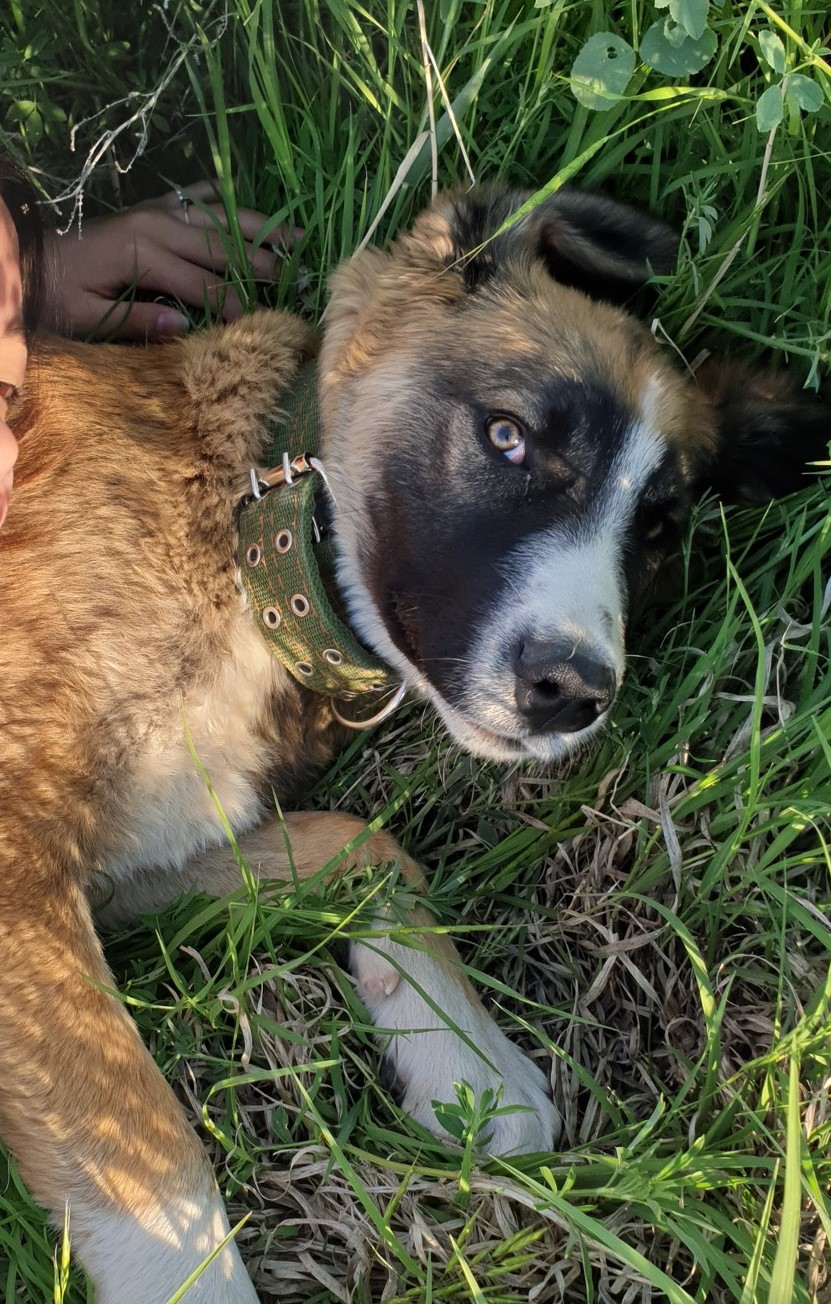


cream


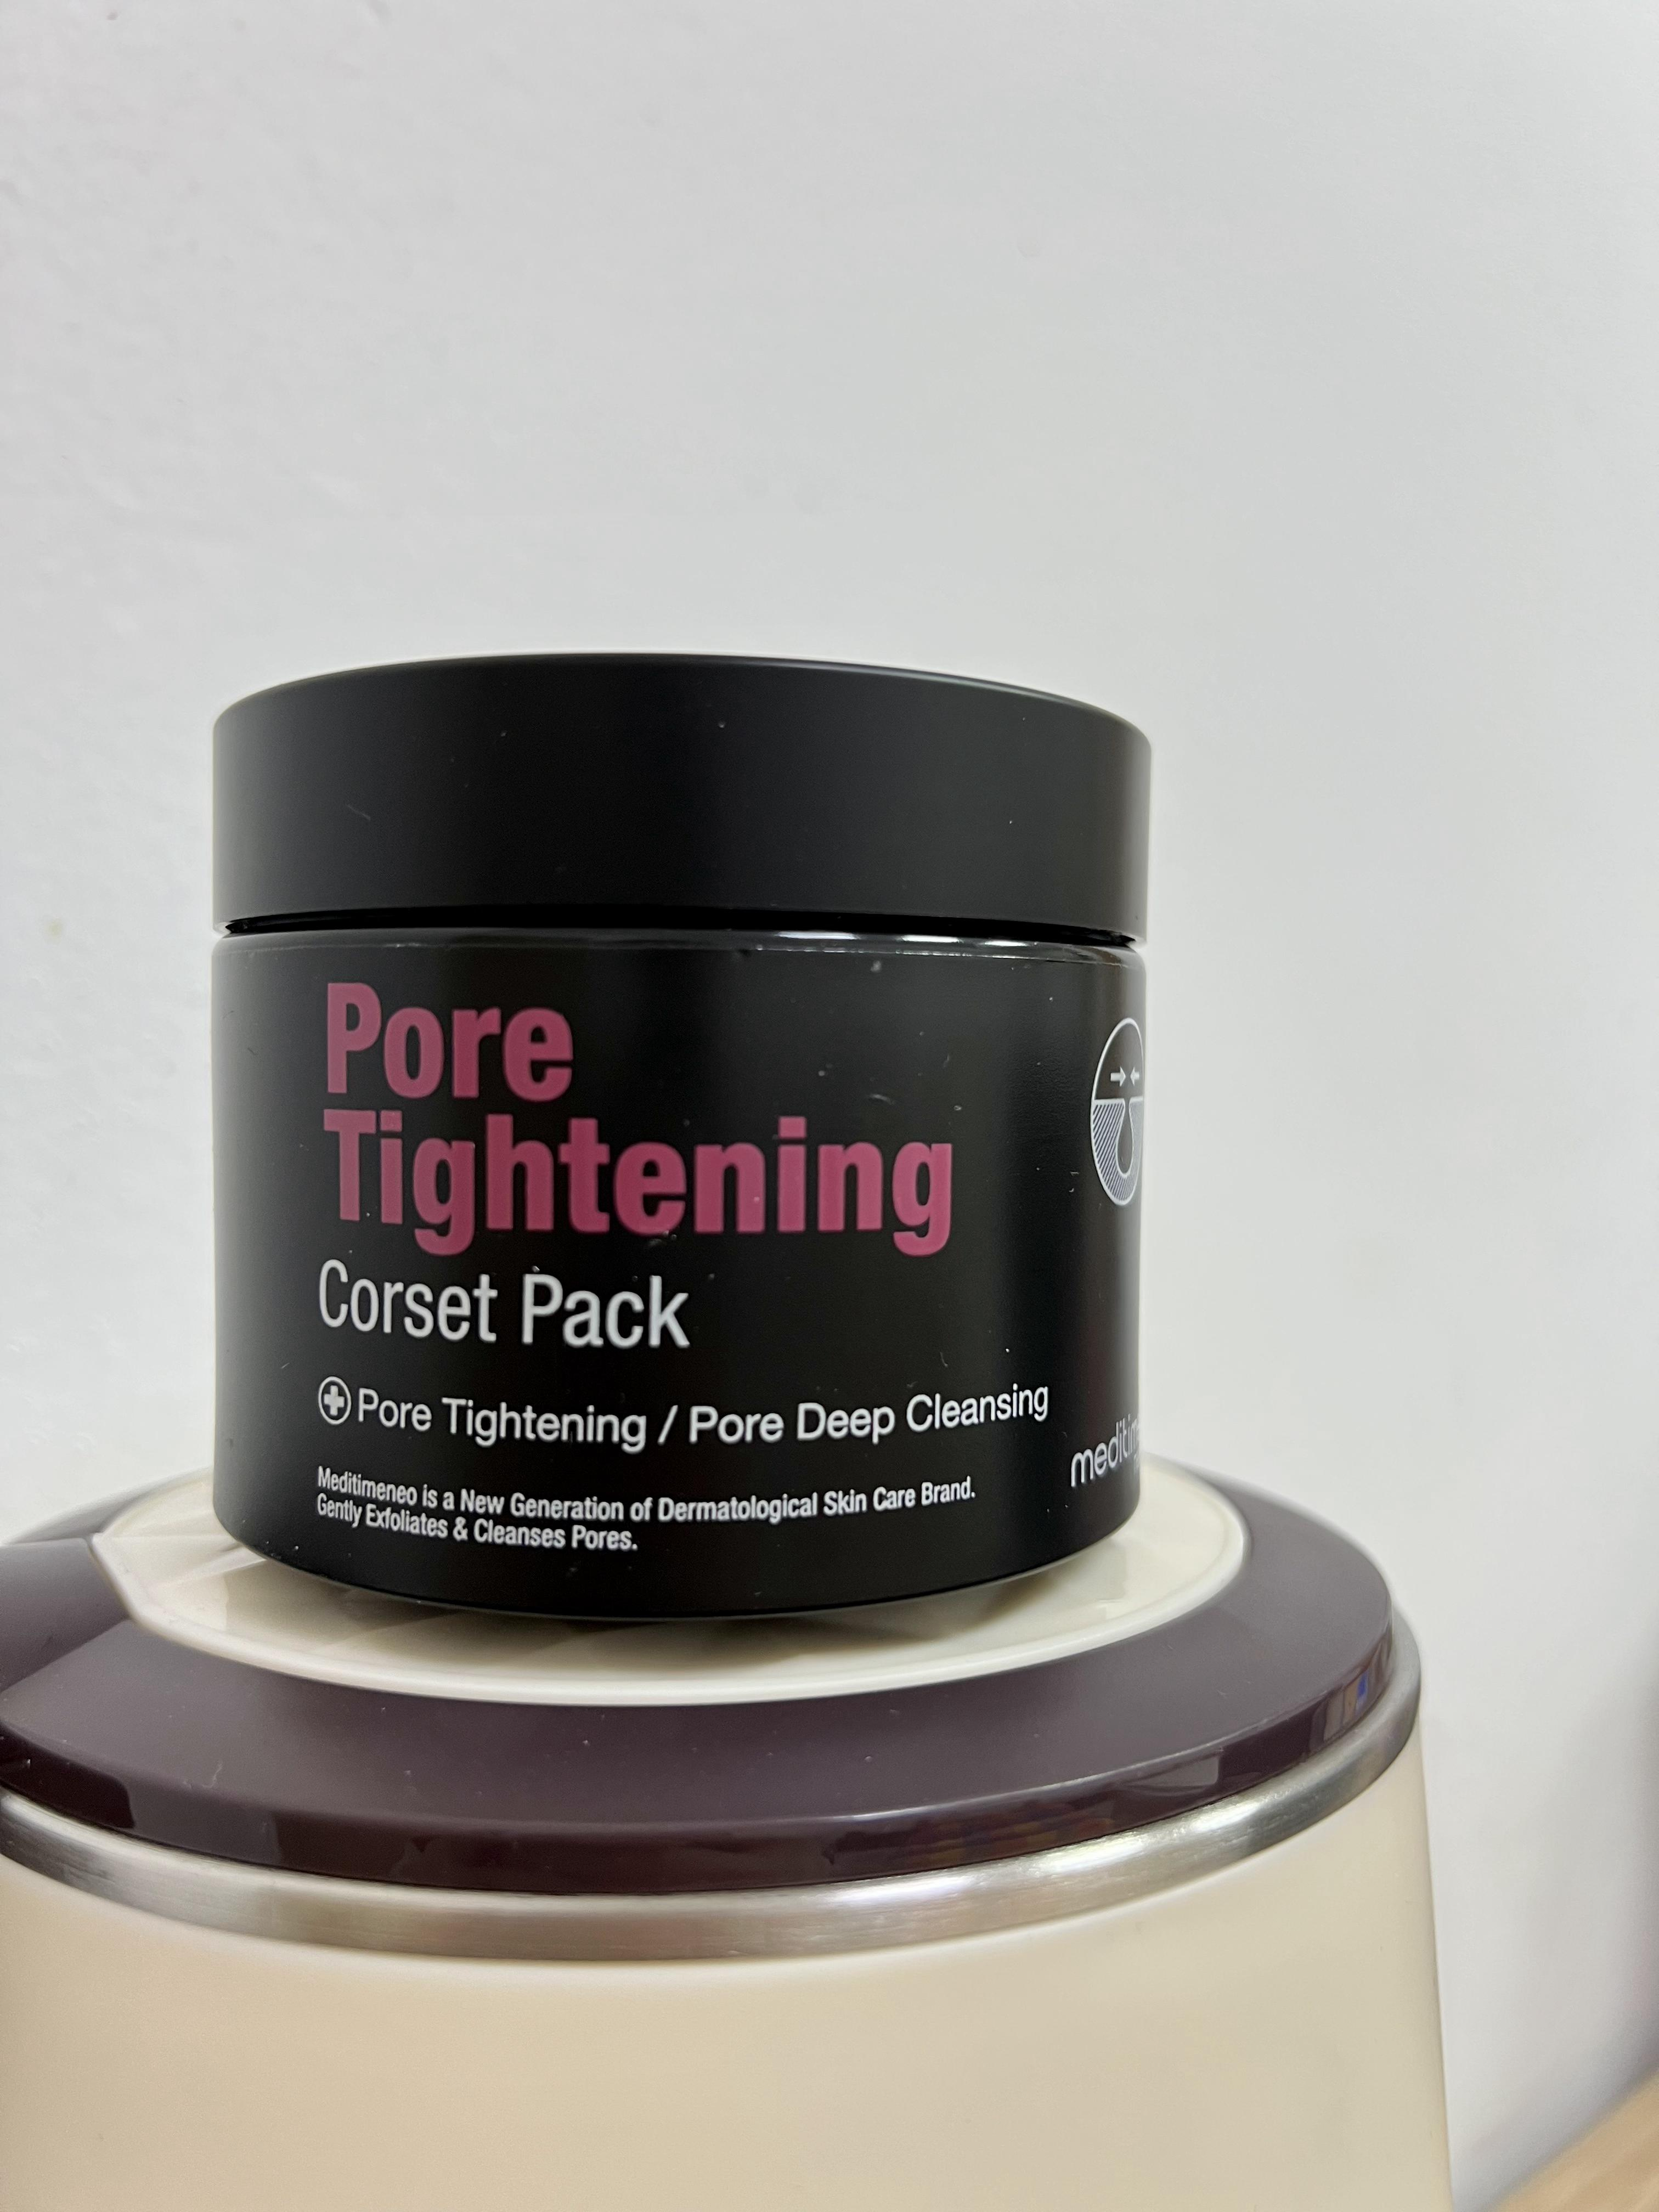


dog


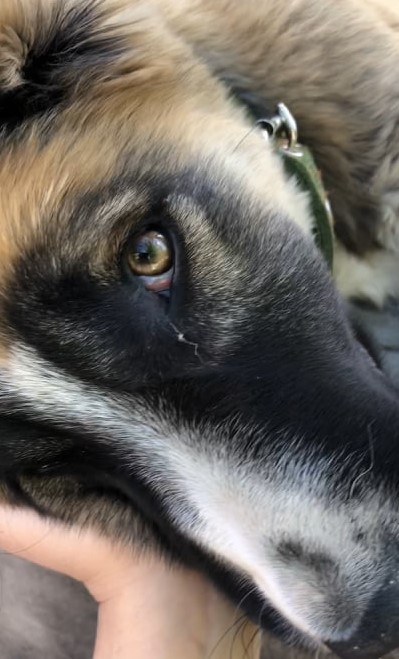

In [ ]:
from PIL import Image

from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)

for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])

  image = Image.open(image_path)
  image = image.resize((100, 100))
  display.display(display.Image(image_path))
  print()

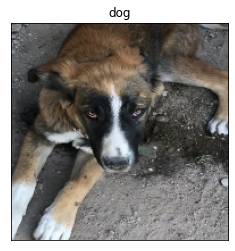

In [ ]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

In [ ]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(3)):
  print(n, img_path)
print()

# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(3)):
  print(n, image.shape)
print()

# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(3):
  print(label_names[label.numpy()])
print()

# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)
print()

for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

0 tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/dataset/dog/photo_2023-02-04_17-06-26.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/dataset/parrots/photo_2023-02-04_13-58-02.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/content/drive/MyDrive/Colab Notebooks/dataset/cream/2023_02_04_00_43_IMG_7613.JPG', shape=(), dtype=string)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)

dog
parrots
cream

<ZipDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

(192, 192, 3) dog
(192, 192, 3) parrots


In [ ]:
# batch and shuffle
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape)

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        color_mode='rgb')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
        dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
        color_mode='rgb')

for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Data batch shape: (32, 192, 192, 3)
Labels batch shape: (32, 3)


In [ ]:
image_size = (150,150)
batch_size = 20


# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)


train_batches = train_datagen.flow_from_directory(
        data_root,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training')


validation_batches = train_datagen.flow_from_directory(
        data_root,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')


Found 150 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


# **Prediction**

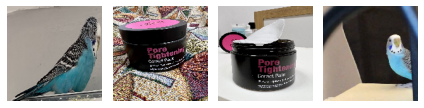

['parrots', 'cream', 'cream', 'parrots']


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4)
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

imgs, labels = train_batches[0]
plotImages(imgs)

def get_class_names(labels, class_names):
    return [class_names[int(label)] for label in labels]

# Convert class IDs to class names
class_names = ['cream', 'dog', 'parrots']
class_names_for_display = get_class_names(labels, class_names)

print(class_names_for_display[:4])

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

def load_dataset(data_root, img_size):
    X_train, y_train, X_val, y_val = [], [], [], []
    for label, class_folder in enumerate(os.listdir(data_root)):
        class_path = os.path.join(data_root, class_folder)
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = image.load_img(img_path, target_size=(img_size, img_size))
            x = image.img_to_array(img) / 255.
            y = label
            if np.random.rand() < 0.5:
                X_val.append(x)
                y_val.append(y)
            else:
                X_train.append(x)
                y_train.append(y)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    return (X_train, y_train), (X_val, y_val)

In [ ]:
# Load the training and validation datasets
(X_train, y_train), (X_val, y_val) = load_dataset(data_root, 192)

In [ ]:
import tensorflow as tf

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)


Epoch 1/10
5/5 [==============================] - 18s 4s/step - loss: 2.8997 - accuracy: 0.3442 - val_loss: 1.1154 - val_accuracy: 0.3288
Epoch 2/10
5/5 [==============================] - 18s 3s/step - loss: 1.0894 - accuracy: 0.3831 - val_loss: 0.9907 - val_accuracy: 0.6027
Epoch 3/10
5/5 [==============================] - 18s 4s/step - loss: 0.8847 - accuracy: 0.6623 - val_loss: 0.8574 - val_accuracy: 0.5959
Epoch 4/10
5/5 [==============================] - 17s 4s/step - loss: 0.5985 - accuracy: 0.7792 - val_loss: 0.7086 - val_accuracy: 0.6781
Epoch 5/10
5/5 [==============================] - 17s 4s/step - loss: 0.3938 - accuracy: 0.8377 - val_loss: 0.7273 - val_accuracy: 0.7397
Epoch 6/10
5/5 [==============================] - 21s 5s/step - loss: 0.2214 - accuracy: 0.9416 - val_loss: 0.9459 - val_accuracy: 0.6712
Epoch 7/10
5/5 [==============================] - 18s 4s/step - loss: 0.3572 - accuracy: 0.8312 - val_loss: 0.7735 - val_accuracy: 0.6918
Epoch 8/10
5/5 [==================

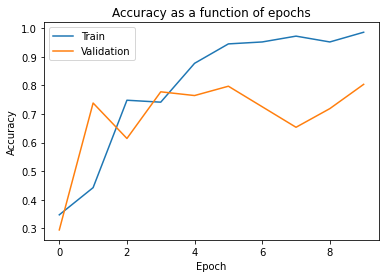

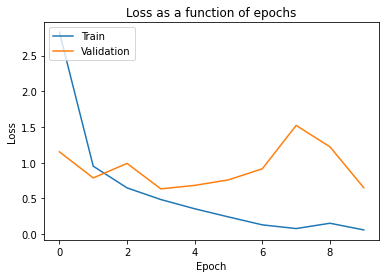

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy as a function of epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss as a function of epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Data augmentation**

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

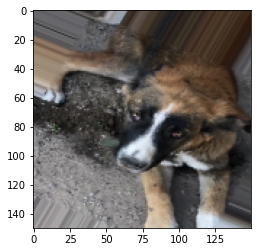

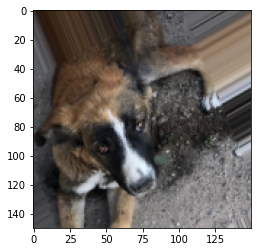

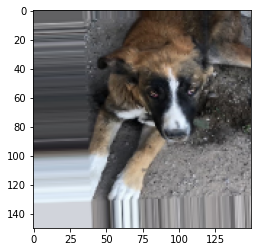

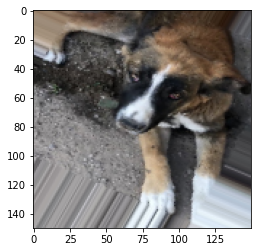

In [ ]:
# This is module with image preprocessing utilities
import keras.utils as image
# Read the image and resize it
img = image.load_img(train_paths[0], target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [ ]:
import numpy as np

# Load the training and validation datasets
(X_train, y_train), (X_val, y_val) = load_dataset(data_root, IMG_SIZE)


# Apply data augmentation to the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images, augmented_labels = [], []
for x, y in train_datagen.flow(X_train, y_train, batch_size=X_train.shape[0]):
    augmented_images.append(x)
    augmented_labels.append(y)
    break

# Combine the augmented images with the original training data
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)

split_index = int(augmented_images.shape[0]/2)
X_val = np.concatenate([X_val, augmented_images[:split_index]])
y_val = np.concatenate([y_val, augmented_labels[:split_index]])
X_train = np.concatenate([X_train, augmented_images[split_index:]])
y_train = np.concatenate([y_train, augmented_labels[split_index:]])

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


# Build the model
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(28, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
9/9 [==============================] - 41s 4s/step - loss: 1.2690 - accuracy: 0.3566 - val_loss: 1.0666 - val_accuracy: 0.3364
Epoch 2/20
9/9 [==============================] - 33s 4s/step - loss: 0.9968 - accuracy: 0.4031 - val_loss: 1.2505 - val_accuracy: 0.4019
Epoch 3/20
9/9 [==============================] - 42s 5s/step - loss: 0.9377 - accuracy: 0.5194 - val_loss: 0.8235 - val_accuracy: 0.5981
Epoch 4/20
9/9 [==============================] - 34s 4s/step - loss: 0.7808 - accuracy: 0.5581 - val_loss: 0.8379 - val_accuracy: 0.5935
Epoch 5/20
9/9 [==============================] - 33s 4s/step - loss: 0.7354 - accuracy: 0.5465 - val_loss: 1.2006 - val_accuracy: 0.4673
Epoch 6/20
9/9 [==============================] - 37s 4s/step - loss: 0.7739 - accuracy: 0.6163 - val_loss: 1.0343 - val_accuracy: 0.5654
Epoch 7/20
9/9 [==============================] - 35s 4s/step - loss: 0.7227 - accuracy: 0.6395 - val_loss: 0.9912 - val_accuracy: 0.5561
Epoch 8/20
9/9 [==================

In [ ]:
# Check the shape of the training and validation datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)

Shape of X_train: (258, 192, 192, 3)
Shape of X_val: (214, 192, 192, 3)


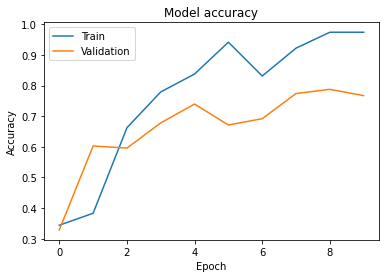

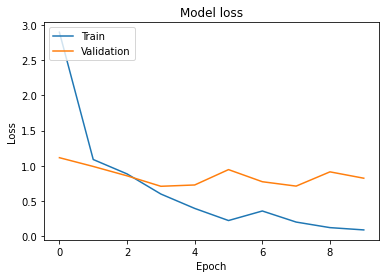

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/10
9/9 [==============================] - 34s 4s/step - loss: 0.3444 - accuracy: 0.8411 - val_loss: 1.1220 - val_accuracy: 0.7243
Epoch 2/10
9/9 [==============================] - 34s 4s/step - loss: 0.3016 - accuracy: 0.8605 - val_loss: 1.2365 - val_accuracy: 0.7290
Epoch 3/10
9/9 [==============================] - 35s 4s/step - loss: 0.2745 - accuracy: 0.8643 - val_loss: 1.3442 - val_accuracy: 0.7103
Epoch 4/10
9/9 [==============================] - 34s 4s/step - loss: 0.3065 - accuracy: 0.8411 - val_loss: 1.4564 - val_accuracy: 0.6869
Epoch 5/10
9/9 [==============================] - 34s 4s/step - loss: 0.3070 - accuracy: 0.8411 - val_loss: 1.6230 - val_accuracy: 0.6869
Epoch 6/10
9/9 [==============================] - 33s 4s/step - loss: 0.4638 - accuracy: 0.7636 - val_loss: 1.5347 - val_accuracy: 0.6075


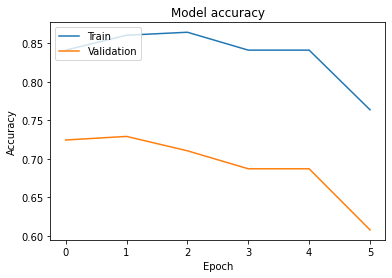

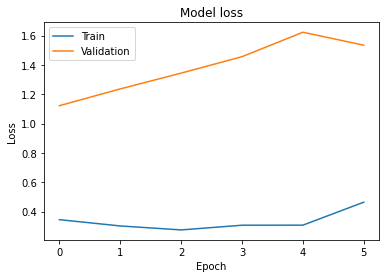

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 2b) Run your model in the browser
Save and download your model, and head to notebook two again. You may not need to make many changes to the starter code, but pay attention to the preprocessing, number of output classes, image size, etc. Take a screenshot of your model running in a webpage and include it with your submission.

In [ ]:
model.save("/content/model_2b.h5")

In [ ]:
!ls -lha

total 365M
drwxr-xr-x 1 root root 4.0K Feb  5 16:38 .
drwxr-xr-x 1 root root 4.0K Feb  5 16:08 ..
drwxr-xr-x 4 root root 4.0K Feb  2 14:39 .config
drwx------ 5 root root 4.0K Feb  5 16:12 drive
-rw-r--r-- 1 root root 365M Feb  5 16:38 model_2b.h5
drwxr-xr-x 1 root root 4.0K Feb  2 14:40 sample_data


In [ ]:
from google.colab import files
files.download("/content/model_2b.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>